# Simple UWB only model

This model was developped when I realized that the simple model had two important issues:

1. First, it supposed that we knew the rotation between the world frame and the earth magnetic frame, as the beacons' coordinates are in world frame, but the attitude of the robot is in earth magnetic frame.
2. The model had a lot of different variances to tune, making the tuning hard to do.

This model removes those issues by relying only on the UWB radio ranging for measurement, and no prediction step.

## Model
The state contains only the position of the robot:

\begin{equation}
\mathbf{x} = \begin{pmatrix}
    x\\
    y
    \end{pmatrix}
\end{equation}

There is no prediction, therefore the prediction step is simply:

\begin{equation}
\mathbf{x}_{k+1} = \mathbf{x}_{k}
\end{equation}

For the measurement, the UWB system gives us the distance $d$ to a beacon.
The beacon's position $\mathbf{b}$ is known and assumed to be fixed.
Therefore the measurement model becomes:

\begin{equation}
h(\mathbf{x}, \mathbf{b}) = \sqrt{(x - b_x)^2 + (y - b_y)^2}
\end{equation}

## Calibrating the variance

To compute the variance of the model, we estimate that the robot is moving at a constant speed of maximum $V_{max}$ between two measurements updates (which occurs at $f_{UWB}$).
Therefore, the maximum distance that a robot can do is given by:

\begin{equation}
d = \frac{V_{max}}{f}
\end{equation}

If we assume that $d = 2 \sigma$, this means that our hypothesis is valid 97.5% of the time.
Therefore, the variance is given by

\begin{equation}
\sigma^2 = \left( \frac{V_{max}}{2 f} \right)^2
\end{equation}

In our example below, if we take $f = 10$ and $V_{max} = 1$, this means that sigma is:

In [1]:
vmax = 1
f = 200
f_uwb = 10
variance = (vmax / (2 * f_uwb))**2
print("Variance = {:.5f}".format(variance))

Variance = 0.00250


For the measurement variance, we measured a few hundred points and got a standard deviation of about 3 cm.

## Simulation

In [2]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import trajectories
import ekf
import functools

%matplotlib inline
sp.init_printing()

In [3]:
# defines a few variables
x, y = sp.symbols('x y')
state = sp.Matrix([x, y])
dt = sp.symbols('Delta_t')
b_x, b_y = sp.symbols('b_x b_y') # beacon position

In [4]:
g = state
h_b = sp.Matrix([sp.sqrt((x - b_x)**2 + (y - b_y)**2)])

BEACON_POS = [
    (-1.5, 0),
    (1.5, 1),
    (1.5, -1),
]

In [5]:
def simulate_trajectory(process_variance, measurement_variance, f=10, N=1000):
    # Empty control input
    u = sp.Matrix([])

    # Prepares the numerical version of the update functions
    g_num = sp.lambdify([state, u], g, 'numpy')
    G_num = sp.lambdify([state, u], g.jacobian(state), 'numpy')
    h_num = sp.lambdify([[b_x, b_y], state], h_b, 'numpy')
    H_num = sp.lambdify([[b_x, b_y], state], h_b.jacobian(state), 'numpy')

    # Sample covariance for the model
    Q_b = np.array([[measurement_variance]])
    R = np.eye(2) * process_variance

    # Prepare the kalman filter
    predictor = ekf.Predictor(g_num, G_num, R)
    correctors = [
        ekf.Corrector(functools.partial(h_num, pos),
                      functools.partial(H_num, pos),
                      Q_b
                     )
    for pos in BEACON_POS]

    mu = np.array([0, 0]) # initial state
    sigma = np.diag([1, 1])

    x, xhat = [], []
    y, yhat = [], []
    ts = []

    for i, p in zip(range(N), trajectories.generate_circular_traj(1, np.deg2rad(10), 1/f)):
        # feeds the input into Kalman
        filter_input = np.array([])
        
        if i % (f / f_uwb) == 0:
            mu, sigma = predictor(mu, sigma, filter_input)
            for corrector in correctors:
                z = corrector.h(np.array([p.pos[0], p.pos[1]]))
                z += np.random.normal(0, 0.01)
                mu, sigma = corrector(mu, sigma, z)

        # Saves the data
        ts.append(p.timestamp)
        x.append(p.pos[0])
        xhat.append(mu[0])
        y.append(p.pos[1])
        yhat.append(mu[1])
        
    return ts, x, y, xhat, yhat

In [6]:
ts, x, y, xhat, yhat = simulate_trajectory(process_variance=0.00250, measurement_variance=0.03**2)

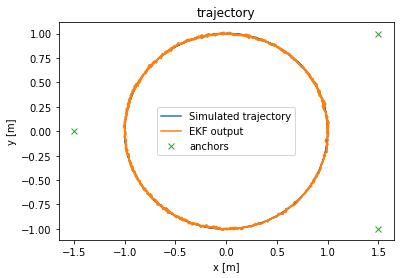

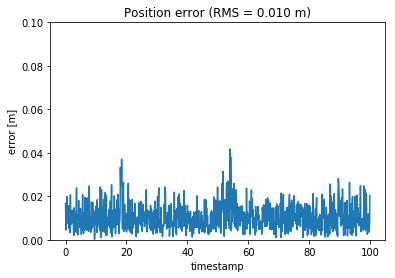

In [7]:
plt.plot(x, y)
plt.plot(xhat, yhat)
plt.plot([x for x, y in BEACON_POS],[y for x, y in BEACON_POS], 'x')
plt.legend(('Simulated trajectory', 'EKF output', 'anchors'))
plt.title('trajectory')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.gcf().savefig('uwb_only_trajectory.pdf')
plt.show()

error = [np.sqrt((x-xh)**2+(y-yh)**2) for x,xh,y,yh in zip(x, xhat,y,yhat)]
plt.plot(ts, error)
plt.xlabel('timestamp')
plt.ylabel('error [m]')
plt.ylim(0, 0.1)
plt.title('Position error (RMS = {:.3f} m)'.format(np.mean(error)))
plt.gcf().savefig('uwb_only_error.pdf')
plt.show()

In [8]:
def cost(variances):
    process_variance = variances[0]
    measurement_variance = variances[1]
    _, x, xh, y, yh = simulate_trajectory(process_variance, measurement_variance, N=100)
    
    return sum(np.sqrt((x-xh)**2+(y-yh)**2) for x,xh,y,yh in zip(x, xhat,y,yhat))

In [9]:
x0 = np.array([0.1**2, 0.03**2])
cost(x0)

array([ 58.15944721])

In [10]:
# We tried to optimize it but its not very efficient
# scipy.optimize.basinhopping(cost, x0, niter=10)